In [1]:
from db import PythonProblemsKohonen
import io
import tokenize
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import random
import time
from itertools import product
from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [22]:
# Input
# from db import PythonProblems
import io

#DB
from questions.models import Solution, Cluster

# Helpers
import numpy as np

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize

In [23]:
from bokeh.models import ColumnDataSource, HoverTool, TapTool, PanTool, WheelZoomTool, Range1d, LinearAxis
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

### Connecting to database

In [24]:
## Cleaning database
last_id = 132
problems = Problem.objects.filter(id__gt=132)
solutions_obj = Solution.objects.filter(problem__in=problems).update(ignore=True)
print(problems.count())
problems = Problem.objects.filter(id__lte=132)
problems.count()

591


132

In [25]:
solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')

In [26]:
solutions_obj.count()

54

In [27]:
docs_id = []
questions = []
solutions = []

for sol in solutions_obj:
    docs_id.append(sol.id)
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

Got 54 documents


***Limitações do parser:***

***1. Variável e nome reservado são do mesmo tipo. Não consigo separar sem fazer uma pré-lista. Mas pode ser o critério para ajustar o CountVectorizer***

***2. Não é possível processar solução sintaticamente errada. Talvez uma tokenização básica possa ajudar quando esse for o caso e já é uma indicação de que está errado.***

### Preprocessing solutions into bag of words ###

In [28]:
vectorizer_params = {
    "ngram_range": (1,3)
}

removed_itens = ['NEWLINE', 'ENDMARKER', "NL", 'COMMENT', 'ERRORTOKEN']
allowed_itens = ['NAME', 'OP', 'INDENT', 'DEDENT', 'STRING', 'NUMBER']

def python_analyzer(doc):
    words = []
    not_found = []
    vectorizer = CountVectorizer(**vectorizer_params)
    file = io.StringIO(doc)
    for token in tokenize.generate_tokens(file.readline):
        token_type = tokenize.tok_name[token[0]]
        
        # Redundant conditional to make sure we're getting all the token types
        if token_type not in removed_itens:
            if token_type in allowed_itens:
                # If it's a variable or reserved name, keep it
                if token_type == "NAME":
                    words.append(token[1])
                elif token_type == "INDENT":
                    # Adding indent for all indentations
                    words.append("is_indent")
                elif token_type == "DEDENT":
                    # Adding dedent for all indentations
                    words.append("is_dedent")
                elif token_type == "STRING":
                    # Adding is_string for every string
                    words.append("is_string")
                elif token_type == "NUMBER":
                    # Adding is_number for every number:
                    words.append("is_number")
                elif token_type == "OP":
                    # If it's operator, then we'll divide in several types
                    lookup = {
                        "+": "is_op_arit",
                        "+=": "is_op_arit",
                        "-": "is_op_arit",
                        "*": "is_op_arit",
                        "**": "is_op_arit",
                        "/": "is_op_arit",
                        "//": "is_op_arit",
                        "%": "is_op_arit",
                        ">": "is_op_logic",
                        "<": "is_op_logic",
                        ">=": "is_op_logic",
                        "<=": "is_op_logic",
                        "==": "is_op_logic",
                        "-=": "is_op_logic",
                        "!=": "is_op_logic",
                        "[": "is_list",
#                         "]": "is_list",
                        "{": "is_dict",
#                         "}": "is_dict",
                        ".": "is_class",
                        "=": "is_attribution",
                        ":": "is_block"
                    }
                    try:
                        words.append(lookup[token[1]])
                    except KeyError:
                        not_found.append(token[1])
#     print("not found: %s" % set(not_found))
    return vectorizer._word_ngrams(words)

In [29]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = TfidfVectorizer(analyzer = python_analyzer,
#                              tokenizer = None, 
#                              preprocessor = None,
#                              stop_words = None,
#                              stop_words = ['def'],   \
                             #max_features = 26d,
                             binary=False,
                             min_df=0.2) 
analyzer = vectorizer.build_analyzer()
    
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(solutions)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# Document-term matrix
train_data_features = train_data_features.toarray()
train_data_features.shape

(54, 44)

### NCut weights

In [30]:
doc_mat_norm = normalize(train_data_features)

In [31]:
S = np.dot(doc_mat_norm.T, doc_mat_norm) + 0.001

In [32]:
S.shape

(44, 44)

In [33]:
D = np.power(np.sum(S, axis=1), -0.5) * np.eye(S.shape[0])

In [34]:
D.shape

(44, 44)

In [35]:
Y = np.dot(D, train_data_features.T)

In [36]:
Y.shape

(44, 54)

# Cálculo da LDA

In [37]:
hover = HoverTool(tooltips=[
#    ("index", "$index"),
    ("(x,y)", "($x{0}, $y)"),
    ("reconst", "@recons"),
])
opts = dict(plot_width=250, plot_height=250, min_border=0)
models = {}

data = {'x_values': [],
        'y_values': [],
        'recons': []}

source = ColumnDataSource(data=data)

opts = dict(plot_width=900, plot_height=500, min_border=0, title="Ncut")
plot = figure(**opts)
plot.add_tools(hover)
l = plot.line(x='x_values', y='y_values', color="#2222aa", line_width=2, source=source)
c = plot.circle(x='x_values', y='y_values', color="#2222aa", fill_color="white", size=8, source=source)
h = show(plot, notebook_handle=True)

In [38]:
def edges_sum(cond_1, cond_2, S):
    nodes_1 = np.where(cond_1)[0]
    nodes_2 = np.where(cond_2)[0]
    
    # Every (x, y) index that I should get cooccurence value from S matrix
    indices = product(nodes_1, nodes_2)
    return np.sum(S[idx] for idx in indices)


def n_cut(mat_U, mat_S):
    
    # Each term belongs to which topic?
    # I can't make this assumption!!! 
    term_clusters = mat_U.argmax(axis=1)
    
    # Number of clusters
    n_k = mat_U.shape[1]
    
    result = 0.0
    for idx_k in range(n_k):
        
        # Check in which cluster the terms come from
        cond_g_k = term_clusters == idx_k
        
        # Sum edges between terms inside cluster and terms outside
        num = edges_sum(cond_g_k, ~cond_g_k, mat_S)
        
        # Sum all edges
        den = edges_sum(cond_g_k,  cond_g_k, mat_S) + num
        
        try:
            result += num/den
        except ZeroDivisionError:
            return 0
        
    return 0.5 * result

In [39]:
num_topics = list(range(2, 44))
#random.shuffle(num_topics)
#random.shuffle(num_topics)
#random.shuffle(num_topics)

In [7]:
NUM_TOPICS = 12
# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_topics=NUM_TOPICS, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(train_data_features)
 
text = "The economy is working better than ever"
x = lda_model.transform(vectorizer.transform([text]))[0]
print(x, x.sum())

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


[0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.5416638
 0.04166667 0.04166667 0.04166953 0.04166667 0.04166667 0.04166667] 1.0


In [14]:
x = lda_model.transform(vectorizer.transform([text[1]]))[0]
x

array([0.00520857, 0.00520835, 0.00520845, 0.00520838, 0.00520851,
       0.00520863, 0.0052085 , 0.00520837, 0.09953174, 0.42653743,
       0.08676354, 0.34549954])

In [20]:
lda_model.components_[9,:]

array([1.79004090e+00, 8.75450341e-02, 8.69800650e-02, 8.75652640e-02,
       8.77472373e-02, 1.01813544e-01, 6.97304621e+00, 7.02313620e+00,
       8.69707805e-02, 2.63903993e-01, 8.75874401e-02, 8.70791181e-02,
       8.73624675e-02, 8.76308797e-02, 8.73521756e-02, 8.66365971e-02,
       8.73801062e-02, 8.73658760e-02, 8.67598581e-02, 8.76904411e-02,
       1.07837391e+00, 8.66239785e-02, 5.24234950e+00, 3.47038399e-01,
       3.52423121e+00, 9.27043824e+00, 8.66303431e-02, 8.84547556e-02,
       8.67390892e-02, 8.72710013e-02, 3.49419361e-01, 8.75916082e-02,
       1.24187052e-01, 8.70372423e-02, 9.93375067e-02, 8.69654287e-02,
       9.82833082e-02, 8.63839884e-02, 8.88689111e-02, 8.71076337e-02,
       8.79424076e-02, 9.28551489e-02, 8.69951821e-02, 8.68863124e-02,
       8.66433957e-02, 8.68141477e-02, 1.32530088e-01, 8.71209664e-02,
       8.76626909e-02, 8.69358304e-02, 8.68388378e-02, 8.73678791e-02,
       2.56349002e+01, 8.66760088e-02, 8.65516666e-02, 8.67257250e-02,
      

In [8]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, train_data_features, vectorizer, mds='tsne')
panel
 

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
0      17.116979        1       1   91.959114  246.738953
4      15.906251        1       2  242.522964  142.058258
8      12.613572        1       3   65.774635  -93.679749
6      10.315522        1       4  -67.469864   -1.039589
9       9.074934        1       5  -94.254189 -181.706970
2       7.558302        1       6   79.381721   68.034569
5       7.179158        1       7  214.252289 -193.921875
10      6.343242        1       8   48.313961 -271.972198
3       4.976830        1       9  235.626923  -26.541155
1       4.030521        1      10  -63.687382  181.563644
7       2.875003        1      11 -213.144073  103.229942
11      2.009689        1      12 -228.521454  -79.501389, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
339   Default  1905.000000        print  1905.000000  30.0000  30.0000
215   Default   242.000000       import   242.000000  29.0000  29.0000
375   Default   328.000000       return   328.000000  28.0000  28.0000
433   Default    82.000000         str1    82.000000  27.0000  27.0000
168   Default   100.000000        float   100.000000  26.0000  26.0000
373   Default   128.000000   result_str   128.000000  25.0000  25.0000
216   Default   521.000000           in   521.000000  24.0000  24.0000
381   Default   126.000000          row   126.000000  23.0000  23.0000
171   Default   445.000000          for   445.000000  22.0000  22.0000
267   Default    80.000000         math    80.000000  21.0000  21.0000
372   Default    82.000000       result    82.000000  20.0000  20.0000
137   Default   229.000000         elif   229.000000  19.0000  19.0000
101   Default   353.000000          def   353.000000  18.0000  18.0000
84    Default    61.000000      counter    61.000000  17.0000  17.0000
432   Default   178.000000          str   178.000000  16.0000  16.0000
358   Default   228.000000        range   228.000000  15.0000  15.0000
280   Default    80.000000        month    80.000000  14.0000  14.0000
356   Default    94.000000       random    94.000000  13.0000  13.0000
218   Default   302.000000        input   302.000000  12.0000  12.0000
245   Default    60.000000           li    60.000000  11.0000  11.0000
83    Default    81.000000        count    81.000000  10.0000  10.0000
299   Default   109.000000          num   109.000000   9.0000   9.0000
97    Default    55.000000      decimal    55.000000   8.0000   8.0000
305   Default    81.000000       number    81.000000   7.0000   7.0000
172   Default   179.000000       format   179.000000   6.0000   6.0000
471   Default    81.000000       tuplex    81.000000   5.0000   5.0000
289   Default    39.000000         name    39.000000   4.0000   4.0000
73    Default    93.000000       column    93.000000   3.0000   3.0000
255   Default    71.000000         list    71.000000   2.0000   2.0000
426   Default    43.000000  startplayer    43.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
401   Topic12     5.738454         setq     6.699727   3.7523  -3.8688
400   Topic12     4.609002         setp     5.572217   3.7174  -4.0880
14    Topic12     3.968244          age     4.927395   3.6907  -4.2377
253   Topic12    27.976185         line    36.122128   3.6516  -2.2846
327   Topic12     6.735356       person     8.858852   3.6331  -3.7086
362   Topic12     8.984466     readline    11.974951   3.6199  -3.4205
364   Topic12     2.038419      release     3.082049   3.4938  -4.9038
80    Topic12     3.478416         copy     5.634955   3.4248  -4.3694
330   Topic12     3.839635     platform     7.884201   3.1877  -4.2706
475   Topic12     2.303807       update     5.292638   3.0754  -4.7814
91    Topic12     2.353683           d2     5.467761   3.0643  -4.7600
90    Topic12     2.3

In [40]:
def coherence_norm(data, tf_idf_norm):
    clusters = np.argmax(data['V_T'], axis=1)
    n_clusters = data['V_T'].shape[1]
    
    clusters_norm = []
    clusters_size = []
    coherence_cluster = []
    
    for idx_cluster in range(n_clusters):
        
        cluster_data = tf_idf_norm[clusters == idx_cluster]
        avg_vector = np.average(cluster_data, axis=0)
        cluster_norm = np.sqrt(np.power(avg_vector, 2).sum())
        clusters_norm.append(cluster_norm)
        clusters_size.append(cluster_data.shape[0])
        
        if cluster_data.shape[0] > 3:
            coherence_cluster.append(cluster_norm)
    
    
    data['avg_clusters_norm'] = clusters_norm
    data['clusters_size'] = clusters_size
    data['coherence_norm'] = np.average(clusters_norm)
    return np.average(coherence_cluster), np.std(clusters_norm)

In [41]:
for key in sorted(models.keys()):
    coherence_norm(models[key], doc_mat_norm)

In [23]:
data_x = sorted(models.keys())
data_ncut = [models[x]["n_cut"]/x for x in data_x]
data_coh = [models[x]["coherence_norm"] for x in data_x]

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x, y)", "($x{0}, $y)"),        ]
    )


plot = figure(title="Ncut vs Coherence", plot_height=500, plot_width=900,
    tools=[hover, PanTool(), WheelZoomTool()])

plot.line(data_x, data_ncut, color="#2222aa", line_width=2)
#plot.circle(data_x, data_ncut, color="#2222aa", fill_color="white", size=8)

plot.extra_y_ranges = {"coherence": Range1d(start=0.0, end=1.0)}
plot.line(data_x, data_coh, line_width=2, color="red", y_range_name="coherence")
plot.add_layout(LinearAxis(y_range_name="coherence"), 'right')

show(plot)

In [25]:
# Take a look at the words in the vocabulary
vocab = vectorizer.get_feature_names()
vocab_cell = np.asarray(vocab).astype(object)

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [30]:
V_T = lda_Z
V_T.shape

(758, 12)

In [31]:
row_sums = V_T.sum(axis=1)
new_matrix = V_T / row_sums[:, np.newaxis]
new_matrix.shape

(758, 12)

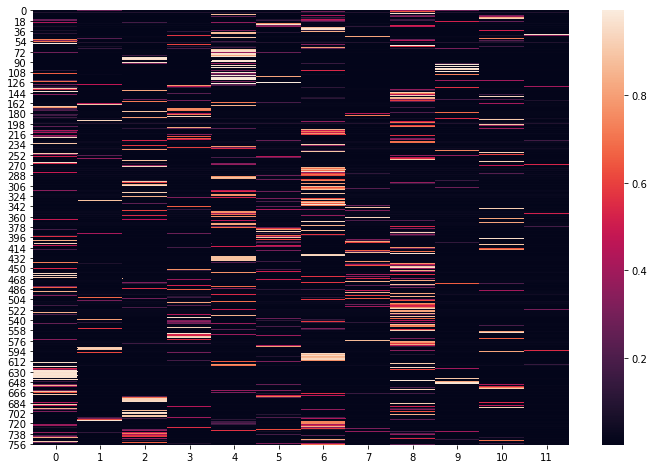

In [32]:
fig = plt.figure(figsize=(12,8))
ax = sns.heatmap(new_matrix)
plt.show()

In [33]:
Counter(np.argmax(V_T, axis=1))

Counter({0: 87,
         1: 30,
         2: 69,
         3: 52,
         4: 98,
         5: 37,
         6: 117,
         7: 32,
         8: 135,
         9: 38,
         10: 54,
         11: 9})

In [34]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [36]:
print("\nTopics in LDA model:")
tfidf_feature_names = vectorizer.get_feature_names()
print_top_words(lda_model, tfidf_feature_names, 26)


Topics in LDA model:
Topic #0: in for range print result_str row return def if and column str game or sum append else hexseg len player dict step int col true winner
Topic #1: print counter decimal startplayer board context import set sety collections setx socket connect value setz prec seta printvalue s1 s2 output def getcontext re color1 color2
Topic #2: print float math input import self pi def sqrt radians area round format height radian sin int volume radius itertools cos sine cn from class return
Topic #3: print li list tuplex in for my_dict words with lambda as append max open my_file min listx num_list tuple printlist keys student def key word_list line
Topic #4: print input format if shoppinglist elif int else false true element item def not len while in finished for temp quote denary menuchoice nomoreswaps binarystring tempitem
Topic #5: return def result count print nums if data in for len hangman guessedcharacters word input num each fib chances append setupvalues while el